In [1]:
I_am = "yael" # change to yuval

if I_am == "yael":
    path_to_initial_sketches = "/home/vinker/dev/background_project/experiements/all_together_09_09/" # to result sketches of the semantic simplification (to calculate the ratios) 
    path_to_files = "/home/vinker/dev/input_images/background_sketching/" # to input images
    path_to_source = "/home/vinker/dev/background_project/quantitative" # results of simplification axis, everything should be under this folder

else: # change to your directories
    path_to_initial_sketches = "" # to result sketches of the semantic simplification (to calculate the ratios) 
    path_to_files = "" # to input images
    path_to_source = "" # results of simplification axis, everything should be under the same folder
    
# write your image names here
images_per_class = {"nature": ["assaf", "house3", "house4", "man_flowers", "yael"], 
                    "people": [], 
                    "urban": ["man_camera", "queen2", "woman_city"], 
                    "animals": ["bull", "cat_c", "dog"], 
                    "indoor": []}
layers = [2,7,8,11]

# Imports

In [2]:
import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import sys 
import torch
import torch.nn as nn
from torchvision import models, transforms
import PIL
from skimage.transform import resize
import torch.nn.functional as F
import matplotlib.cm as cm
import shutil


p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid
from scipy.optimize import curve_fit

import notebooks_utils

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

# Utils

In [3]:
def ratios_to_str(ratios):
    ratios_str = ""
    for r_ in ratios:
        r_str = f"{r_:.3f}"
        ratios_str += f"{float(r_str)},"
    ratios_str = ratios_str[:-1]
    return ratios_str

def get_clip_loss(path, layer, object_or_background):
    path_config = f"{path}/config.npy"
    config = np.load(path_config, allow_pickle=True)[()]
    loss_clip = np.array(config[f"loss_eval"])
    best_iter = np.argsort(loss_clip)[0]
    loss_clip_layer = np.array(config[f"clip_vit_l{layer}_original_eval"])
    if object_or_background == "object":
        loss_clip_layer4 = np.array(config[f"clip_vit_l4_original_eval"])
        loss_clip_layer = 1*loss_clip_layer4 + loss_clip_layer
    return best_iter, loss_clip_layer

def func(x, a, c, d):
    return a*np.exp(c*x)

def func_inv(y,a,c,d):
    return np.log(y / a) * (1 / c)

def get_func(ratios_rel, start_x, start_ys):
    target_ys = ratios_rel[start_ys:]
    x = np.linspace(start_x, start_x + len(target_ys) - 1, len(target_ys))
    # calculate polynomial
    popt, pcov = curve_fit(func, x, target_ys, maxfev=3000)
    return popt

def get_ratios_srt2(path_to_initial_sketches, folder_name_l, layer, object_or_background, step_size_l, num_ratios=8):
    svg_filename = notebooks_utils.get_svg_path(f"{path_to_initial_sketches}/{folder_name_l}")
    seed = notebooks_utils.get_seed(svg_filename)
    path_li = f"{path_to_initial_sketches}/{folder_name_l}/{folder_name_l}_seed{seed}"
    best_iter, loss_clip_layer = get_clip_loss(path_li, layer, object_or_background)
    best_lclip_layer = loss_clip_layer[best_iter]
    r_1_k = 1 / best_lclip_layer
    
    # get the next ratios by jumping by 2
    r_j_k = r_1_k
    ratios_k = [r_1_k]
    for j in range(4):
        r_j_k = r_j_k / 2
        ratios_k.append(r_j_k)
    start_ys, start_x, end_x_addition = 0, 0, 0
    popt = get_func(ratios_k, start_x=0, start_ys=0) # fit the function to ratios_k
    # print(popt)
    # print(f"function :a*exp(c*x)")
    x_1_k = func_inv([r_1_k], *popt)

    step_size = step_size_l
    num_steps = num_ratios - start_x + end_x_addition
    start_ = x_1_k[0]
    end = num_steps * step_size
    # sample the function from the initial scaled r_1 with the corresponding step size
    new_xs_layer_l = np.linspace(start_, end - step_size + start_, num_steps) 
    # print("new_xs_layer_l", new_xs_layer_l)
    ratios_li = func(new_xs_layer_l, *popt)
    ratios_str = ratios_to_str(ratios_li)
    xs_layer_l_str = ratios_to_str(new_xs_layer_l)
    # print(f"layer {layer} r_1_k {r_1_k} \n new {ratios_str} \n x {xs_layer_l_str}\n")
    return ratios_str


def get_res_filename(im_name_, object_or_background, layer, resize_obj):
    im_name = im_name_
    if object_or_background == "background":
        im_name = f"{im_name_}_mask"
    res_filename = f"{object_or_background}_l{layer}_64s_{im_name}"
    if resize_obj:
        res_filename += f"_resize{resize_obj}"
    path_res = f"{path_to_initial_sketches}/{res_filename}"
    if not os.path.isdir(path_res):
        res_filename = f"{res_filename}_resize{resize_obj}"
    return res_filename


def get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, path_to_res):
    test_name_pref = f"l{layer}_64s_{im_name}_{min_div}"
    if resize_obj:
        test_name_pref += f"_resize{resize_obj}"
    res_filename = f"ratio{r}_{test_name_pref}"
    path_res = f"{path_to_res}/{res_filename}"
    if not os.path.isdir(path_res):
        res_filename = f"{res_filename}_resize{resize_obj}"
    path_res = f"{path_to_res}/{res_filename}"
    if not os.path.isdir(path_res):
        test_name_pref = f"l{layer}_64s_{im_name}_{ablation_name_pref}"
        res_filename = f"ratio{r}_{test_name_pref}"
    return res_filename    

# Stroke count script

In [4]:
def get_strokes_count(object_or_background, resize_obj, im_name_, divs, layers):
    strokes_per_layer = {}
    im_name = im_name_
    if object_or_background == "background":
        im_name = f"{im_name_}_mask"
    for i, layer in enumerate(layers):
        strokes_per_layer[layer] = []
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_org = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)        
        ratios = [float(item) for item in ratios_org.split(',')]
        for j, r in enumerate(ratios):
            res_filename = get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, path_to_source)
            best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_source}/{res_filename}")
            path_svg = f"{path_to_source}/{res_filename}/{best_svg_filename}"
            canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(path_svg)
            strokes_count = 0
            for path in shapes:
                w = path.stroke_width / 1.5
                if w > 0.7:
                    strokes_count += 1
            strokes_per_layer[layer].append(strokes_count)
    return strokes_per_layer

def get_strokes_count_dict():
    strokes_per_image = {}
    for class_name in images_per_class.keys():
        print("=" * 10, class_name, "=" * 10)
        for im_name_ in images_per_class[class_name]:
            print("-" * 10, im_name_, "-" * 10)
            strokes_per_image[im_name_] = {}

            # background
            divs = [0.35, 0.45, 0.5, 0.9]
            object_or_background, resize_obj = "background", 0
            strokes_per_layer = get_strokes_count(object_or_background, resize_obj, im_name_, divs, layers)
            strokes_per_image[im_name_]["background"] = strokes_per_layer

            # object
            divs = [0.45,0.4,0.5,0.9]
            object_or_background, resize_obj = "object", 1
            strokes_per_layer = get_strokes_count(object_or_background, resize_obj, im_name_, divs, layers)
            strokes_per_image[im_name_]["object"] = strokes_per_layer
    return strokes_per_image

strokes_per_image = get_strokes_count_dict()

========== nature ==========
---------- assaf ----------


/home/miniconda/envs/habitat/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


---------- house3 ----------
---------- house4 ----------
---------- man_flowers ----------
---------- yael ----------
========== people ==========
========== urban ==========
---------- man_camera ----------
---------- queen2 ----------
---------- woman_city ----------
========== animals ==========
---------- bull ----------
---------- cat_c ----------
---------- dog ----------
========== indoor ==========


In [6]:
np.save("all.npy", strokes_per_image)

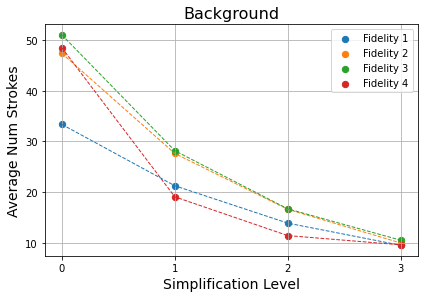

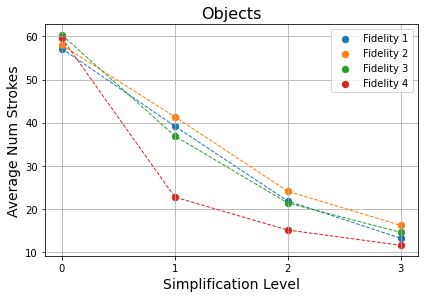

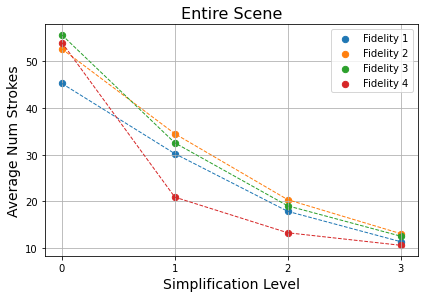

In [5]:
# analyse the results and plot the graph

def get_avg_stroke_count(object_or_background):
    strokes_count_avg = {}
    for l in layers:
        strokes_count_avg[l] = np.zeros(8)
    for im_name in strokes_per_image.keys():
        s_count = strokes_per_image[im_name][object_or_background]
        for l in layers:
            strokes_count_avg[l] += (np.array(s_count[l]) / len(strokes_per_image.keys()))
    return strokes_count_avg

def plot_num_strokes(strokes_count_avg, step=1, title=""):
    ylabel = "Average Num Strokes"
    xlabel = "Simplification Level"
    for i, l in enumerate(strokes_count_avg.keys()):
        num_s = strokes_count_avg[l][::step]
        plt.plot(range(len(num_s)), num_s, linewidth=1, ls="--")
        plt.scatter(range(len(num_s)), num_s, label=f"Fidelity {i + 1}", s=40)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    # plt.title("Avg. Number of Strokes", fontsize=18)
    plt.xticks(range(len(num_s)))
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.title(title, fontsize=16)
    plt.show()

strokes_count_avg_b = get_avg_stroke_count("background")
plot_num_strokes(strokes_count_avg_b, step=2, title="Background")

strokes_count_avg_o = get_avg_stroke_count("object")
plot_num_strokes(strokes_count_avg_o, step=2, title="Objects")

strokes_count_avg_all = {}
for l in strokes_count_avg_b.keys():
    strokes_count_avg_all[l] = (strokes_count_avg_b[l] + strokes_count_avg_o[l]) / 2

plot_num_strokes(strokes_count_avg_all, step=2, title="Entire Scene")

# Internal script for Yael to copy the files (Yuval - Ignore)

In [119]:
layers = [2, 7, 8, 11]

images = ["queen2"]
# panda
path_to_res = "/home/vinker/dev/background_project/experiements/ratio_14_10"
output_path = "/home/vinker/dev/background_project/quantitative"
for im_name_ in images:
    print(im_name_)
    for i, layer in enumerate(layers):
        print(layer)
        # background
        divs = [0.35, 0.45, 0.5, 0.9]
        object_or_background, resize_obj, im_name = "background", 0, f"{im_name_}_mask"
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_org = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)        
        ratios = [float(item) for item in ratios_org.split(',')]
        for j, r in enumerate(ratios):
            res_filename = get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, path_to_res)
            if not os.path.exists(f"{output_path}/{res_filename}"):
                os.mkdir(f"{output_path}/{res_filename}")
            best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res}/{res_filename}")
            path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"
            # print(path_best_im, f"{output_path}/{res_filename}/{best_svg_filename}")
            shutil.copyfile(path_best_im, f"{output_path}/{res_filename}/{best_svg_filename}")
            
            
        # object
        divs = [0.45,0.4,0.5,0.9]
        object_or_background, resize_obj, im_name = "object", 1, f"{im_name_}"
        res_filename = get_res_filename(im_name_, object_or_background, layer, resize_obj)
        min_div = divs[i]
        ratios_org = get_ratios_srt2(path_to_initial_sketches, res_filename, layer, object_or_background, min_div, num_ratios=8)        
        ratios = [float(item) for item in ratios_org.split(',')]
        for j, r in enumerate(ratios):
            res_filename = get_res_filename_ratio(layer, im_name, min_div, resize_obj, r, path_to_res)
            # print(res_filename)
            if not os.path.exists(f"{output_path}/{res_filename}"):
                os.mkdir(f"{output_path}/{res_filename}")
            best_svg_filename = notebooks_utils.get_svg_path(f"{path_to_res}/{res_filename}")
            path_best_im = f"{path_to_res}/{res_filename}/{best_svg_filename}"
            # print(path_best_im, f"{output_path}/{res_filename}/{best_svg_filename}")
            shutil.copyfile(path_best_im, f"{output_path}/{res_filename}/{best_svg_filename}")
            

queen2
2
7
8
11
